# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [6]:
test.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [7]:
train = train.fillna("")#, inplace=True)
test = test.fillna("")

In [8]:
train.isnull().any().sum() # больше пропусков нет

0

In [9]:
test.isnull().any().sum()

0

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [10]:
train['target'].value_counts()

0    3024
1    2305
Name: target, dtype: int64

###### Выборка не очень сбалансированная. Из-за этого в последнем задании при инициализации логистической регрессии для лучшего результата сделаем сбалансированные веса 
###### Заметим еще, что если ключевым словом в keyword является не слово, а сочетание слов, то пробелы там заменяются на "%20", что потом может привести к потере данных. Заменим обратно "%20" на пробелы

In [11]:
def whitespace(string: str):
    return re.sub(r'(%20)', ' ', string)

train.rename(columns={'keyword': 'kword'}, inplace=True)
test.rename(columns={'keyword': 'kword'}, inplace=True)   
train['keyword'] = [whitespace(kword) for kword in train['kword'].values]
test['keyword'] = [whitespace(kword) for kword in test['kword'].values]
train.drop('kword', axis=1, inplace=True)
test.drop('kword', axis=1, inplace=True)

In [12]:
train

,id,location,text,target,keyword
1186,1707,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,bridge collapse
4071,5789,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1,hail
5461,7789,Houston,CNN: Tennessee movie theater shooting suspect ...,1,police
5787,8257,,Still rioting in a couple of hours left until ...,1,rioting
7445,10656,Lake Highlands,Crack in the path where I wiped out this morni...,0,wounds
...,...,...,...,...,...
5226,7470,Merica!,@Eganator2000 There aren't many Obliteration s...,0,obliteration
5390,7691,,just had a panic attack bc I don't have enough...,0,panic
860,1242,,Omron HEM-712C Automatic Blood Pressure Monito...,0,blood
7603,10862,,Officials say a quarantine is in place at an A...,1,


я строю диаграмму не по 10-ти, а по 15-ти (считая пустую строку) наиболее частым ключевым словам, так как если брать только 10, то охватываются не все слова, повторяющиеся 30 раз. не хочу для диаграммы выкидывать какие-то ключевые слова просто потому что они по отсортиваны дальше других, несмотря на одну и ту же частоту встречи

In [13]:
kwords = train['keyword'].value_counts()[:15].index.tolist()

In [14]:
# tweets = []
# for kword in kwords:
#     tweets.append(train[train['keyword'] == kword])
# frequent_tweets = pd.concat(tweets)
frequent_tweets = train[train['keyword'].isin(kwords)]

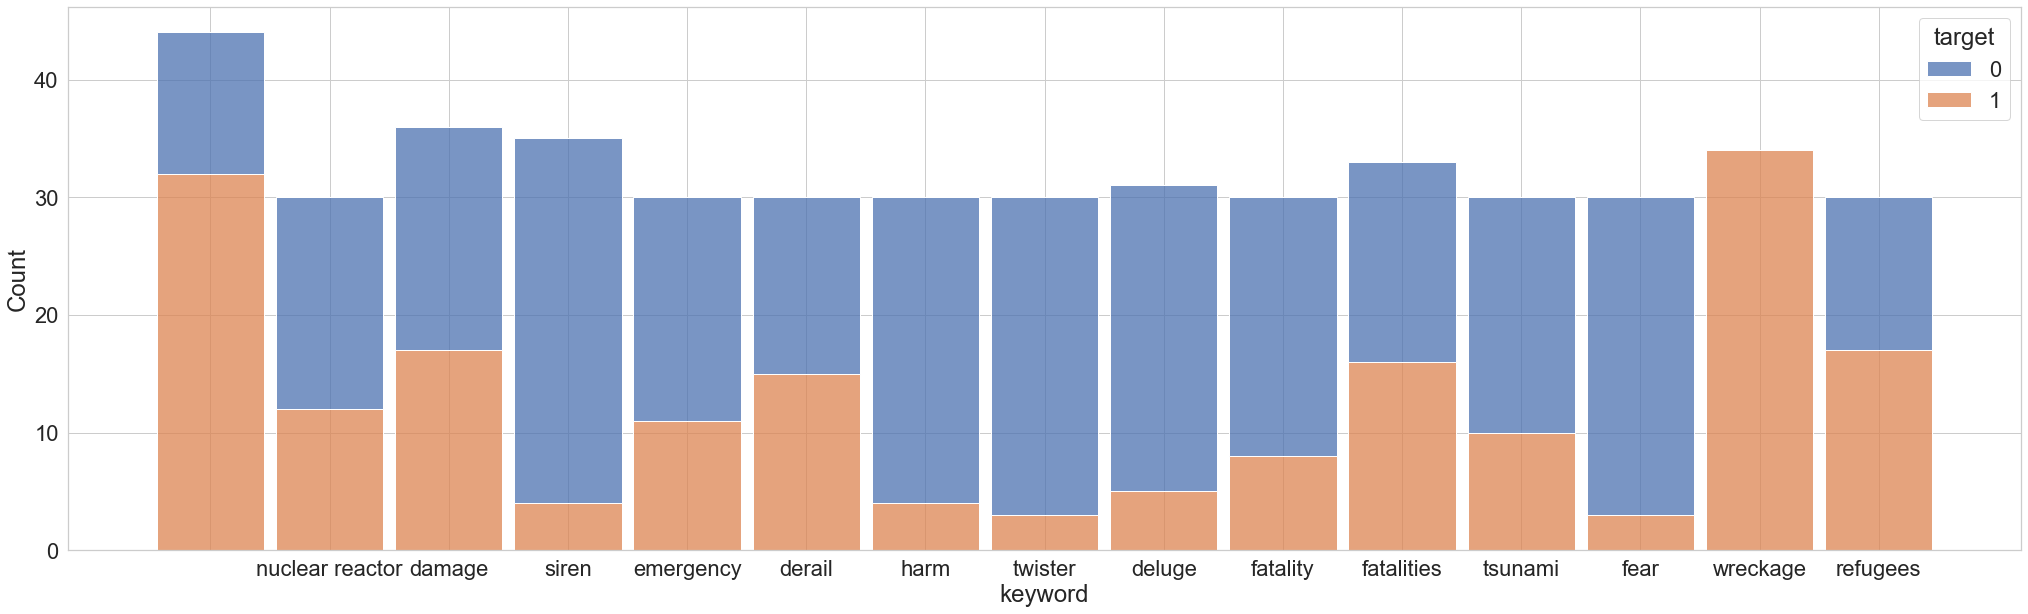

In [15]:
plt.figure(figsize = (35,10))
sns.set(font_scale=2, style="whitegrid")
sns.histplot(x=frequent_tweets['keyword'], hue=frequent_tweets['target'], multiple='stack', shrink=0.9)#, palette='pastel')#{0:'r',1:'g' })


        Вывод
многие слова, которые логично было бы отнести к твитам про реальные катастрофы, тем не менее в основном встречаются в обычных твитах не про катастрофы. лишь по нескольким (из часто встречающихся) словам можно будет уверенно предсказывать класс

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [16]:
train.drop('id', axis=1, inplace=True)

In [17]:
test.drop('id', axis=1, inplace=True)

In [18]:
train

,location,text,target,keyword
1186,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,bridge collapse
4071,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1,hail
5461,Houston,CNN: Tennessee movie theater shooting suspect ...,1,police
5787,,Still rioting in a couple of hours left until ...,1,rioting
7445,Lake Highlands,Crack in the path where I wiped out this morni...,0,wounds
...,...,...,...,...
5226,Merica!,@Eganator2000 There aren't many Obliteration s...,0,obliteration
5390,,just had a panic attack bc I don't have enough...,0,panic
860,,Omron HEM-712C Automatic Blood Pressure Monito...,0,blood
7603,,Officials say a quarantine is in place at an A...,1,


In [19]:
train['text'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']
train.drop(['keyword', 'location'], axis=1, inplace=True)

In [20]:
test['text'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']
test.drop(['keyword', 'location'], axis=1, inplace=True)

In [21]:
train

,text,target
1186,bridge collapse Ashes 2015: AustraliaÛªs col...,0
4071,"hail Carol Stream, Illinois GREAT MICHIGAN TEC...",1
5461,police Houston CNN: Tennessee movie theater s...,1
5787,rioting Still rioting in a couple of hours le...,1
7445,wounds Lake Highlands Crack in the path where ...,0
...,...,...
5226,obliteration Merica! @Eganator2000 There aren'...,0
5390,panic just had a panic attack bc I don't have...,0
860,blood Omron HEM-712C Automatic Blood Pressure...,0
7603,Officials say a quarantine is in place at an...,1


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [23]:
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['text'])
X #размер матрицы 5329x18425, т.е. в ней 18425 различных уникальных слов/символов

<5329x18425 sparse matrix of type '<class 'numpy.int64'>'
	with 85877 stored elements in Compressed Sparse Row format>

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [24]:
def has_numbers(inputString: str)->bool:
    return bool(re.search(r'\d', inputString))
def has_punc(inputString: str)->bool:
    return bool(re.search(r'[!"$%&\'\#\@()*+, -./:;<=>?\\[\]^_`{|}~]', inputString))
def is_hashtag(inputString: str)->bool:
    return bool(re.match(r'#.', inputString))
def is_mention(inputString: str)->bool:
    return bool(re.match(r'@.', inputString))

In [25]:
def count_stat3(voc: dict):
    numbers = sum(list(map(has_numbers, voc.keys())))
    punct = sum(list(map(has_punc, voc.keys())))
    hashtags = sum(list(map(is_hashtag, voc.keys())))
    mentions = sum(list(map(is_mention, voc.keys())))
    return [numbers, punct, hashtags, mentions]

def count_stat2(voc: dict):
#     count_numb = 0
    has_numb = 0
#     count_punct = 0
    has_punct = 0
#     hashtags = 0
    unique_hashtags = 0
#     mentions = 0
    unique_mentions = 0
    for i in voc:
        if has_numbers(i):
            has_numb += 1
#             count_numb += voc[i]
        if has_punc(i):
            has_punct += 1
#             count_punct += voc[i]
        if is_hashtag(i):
            unique_hashtags+= 1
#             hashtags += voc[i]
        if is_mention(i):
            unique_mentions += 1
#             mentions += voc[i]
    return [has_numb, has_punct, unique_hashtags, unique_mentions]
#     return [(has_numb, count_numb), (has_punct, count_punct), (unique_hashtags, hashtags), (unique_mentions, mentions)]
        

def count_stat(voc: dict):
    with_numbers = sum(1 for _ in filter(has_numbers, voc.keys()))
    with_punc = sum(1 for _ in filter(has_punc, voc.keys()))
    hashtags = sum(1 for _ in filter(is_hashtag, voc.keys()))
    mentions = sum(1 for _ in filter(is_mention, voc.keys()))
    
    return [with_numbers, with_punc, hashtags, mentions]

stat = count_stat(cnt_vec.vocabulary_ )
labels = ['Слова, содержащие цифры:', 'Слова, содержащие символы пунктуации:', 'Хэштэги:', 'Упоминания:']
for unique, label in zip(stat, labels):
    print(f'\t{label}\nУникальных слов:\t{unique}')#, всего их встречается в твитах:\t{count}\n')

	Слова, содержащие цифры:
Уникальных слов:	3782
	Слова, содержащие символы пунктуации:
Уникальных слов:	315
	Хэштэги:
Уникальных слов:	0
	Упоминания:
Уникальных слов:	0


###### Просто из интереса для сравнения времени выполнения сделала три разных способа подсчета статистики: count_stat2 использует напрямую цикл for, и хотя код реально не самый красивый, но по времени он занимает не больше, чем методы **count_stat**  и count_stat3 со встроенными питоновскими функциями ( map/filter ), хотя в них по идее осуществляется минимум 4 цикла по всему словарю

In [26]:
%%time
print(count_stat3(cnt_vec.vocabulary_))

[3782, 315, 0, 0]
CPU times: user 120 ms, sys: 4.21 ms, total: 124 ms
Wall time: 143 ms


In [27]:
%%time
print(count_stat2(cnt_vec.vocabulary_))

[3782, 315, 0, 0]
CPU times: user 122 ms, sys: 4.07 ms, total: 126 ms
Wall time: 137 ms


In [28]:
%%time
print(count_stat(cnt_vec.vocabulary_))

[3782, 315, 0, 0]
CPU times: user 110 ms, sys: 4.21 ms, total: 114 ms
Wall time: 120 ms


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [29]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
tw = TweetTokenizer()
cnt_vec_tw = CountVectorizer(tokenizer=tw.tokenize)
X2 = cnt_vec_tw.fit_transform(train['text'])
X2 # токенов стало больше, теперь 19638

<5329x19638 sparse matrix of type '<class 'numpy.int64'>'
	with 92959 stored elements in Compressed Sparse Row format>

In [30]:
stat2 = count_stat(cnt_vec_tw.vocabulary_ )
for count, label in zip(stat2, labels):
    print(f'\t{label}\nУникальных слов:\t{count}')

	Слова, содержащие цифры:
Уникальных слов:	3910
	Слова, содержащие символы пунктуации:
Уникальных слов:	7339
	Хэштэги:
Уникальных слов:	1469
	Упоминания:
Уникальных слов:	1678


## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [31]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [32]:
stop_words = stopwords.words('english')

In [33]:
# возвращает true, если есть символы кроме латинских букв
def nonlatin_letters(string:str)->bool:
    return bool(re.search(r'([^a-zA-Z])', string))

#так как твиты английские (не на иврите/арабском))) и нам надо считать за смайлики только токены, содержащие скобочку, 
# я допускаю эту скобочку только в конце токена
def is_smile(inputString: str)->bool: 
    return bool(re.search(r'^[^\w\n]*[()]+$', inputString))

# возвращает true, только если это хэштег, содержащий только латинские буквы и нижнее подчеркивание (часто встречается в хэштегах)
def is_hashtag(inputString: str)->bool:
    return bool(re.match(r'#[a-zA-Z_]+$', inputString))

def valid_token(inputString: str)->bool:
    if nonlatin_letters(inputString):
        if is_hashtag(inputString) or is_smile(inputString):
            return True
    elif inputString in stop_words:
            return False
    else:
        return True
        
# def custom_tokenizer2(stopwords, string: str):
#     string = string.lower() #make all lower case
#     twt = TweetTokenizer()
#     stemmer = SnowballStemmer('english')
#     tokens = twt.tokenize(string)
#     i = len(tokens)

#     while i > 0:
#         token = tokens[i-1]
#         if nonlatin_letters(token):
#             if not is_smile(token) and not is_hashtag(token):
#                 del tokens[i-1]
#         elif token in stopwords:
#                 del tokens[i-1]
#         i -= 1
#     stemmed = [stemmer.stem(w) for w in tokens]
    
#     return stemmed

def custom_tokenizer(string: str):
    string = string.lower() #make all lower case
    twt = TweetTokenizer()

    tokens = twt.tokenize(string) # токенизируем
    filtered = filter(valid_token, tokens) #фильтруем , убирая все слова из стоп-слов и содержащие нелатинские буквы, кроме хэштегов и смайлов
    
    stemmer = SnowballStemmer('english')
    stemmed = [stemmer.stem(w) for w in filtered]
    return stemmed


In [34]:
texts = train['text'].head(10).values
for i in texts:
    print(f"\tИзначальный текст:\n{i}\n\tПосле обработки:\n{custom_tokenizer(i)}\n")

	Изначальный текст:
bridge collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
	После обработки:
['bridg', 'collaps', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']

	Изначальный текст:
hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
	После обработки:
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']

	Изначальный текст:
police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
	После обработки:
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']

	Изначальный текст:
rioting  Still rioting in a couple of hours left until I have to be up for class.
	После обработки:
['riot', 

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [36]:
cnt_vec_custom = CountVectorizer(tokenizer=custom_tokenizer)
train_txt = cnt_vec_custom.fit_transform(train['text'])
test_txt = cnt_vec_custom.transform(test['text'])

In [37]:
clf = LogisticRegression(random_state=13).fit(train_txt, train['target'])
pred = clf.predict(test_txt)
print(classification_report(test['target'], pred))
print('F1-score with CountVectorizer: ', round(f1_score(test['target'], pred), 5))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1318
           1       0.79      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

F1-score with CountVectorizer:  0.75364


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [38]:
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
train_tfidf = tfidf_vec.fit_transform(train['text'])
test_tfidf = tfidf_vec.transform(test['text'])
clf_tfidf = LogisticRegression(random_state=13).fit(train_tfidf, train['target'])
pred2 = clf_tfidf.predict(test_tfidf)
print(classification_report(test['target'], pred2))
print('F1-score with TfidfVectorizer: ', round(f1_score(test['target'], pred2), 5))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

F1-score with TfidfVectorizer:  0.74349


In [39]:
train_tfidf

<5329x10481 sparse matrix of type '<class 'numpy.float64'>'
	with 50966 stored elements in Compressed Sparse Row format>

###### Качество метрики f1-score изменилось в худшую сторону на 0.01. Изменение не самое внушительное)

In [40]:
tfidf_vec2 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
train2_tfidf = tfidf_vec2.fit_transform(train['text'])
test2_tfidf = tfidf_vec2.transform(test['text'])
clf2_tfidf = LogisticRegression(random_state=13).fit(train2_tfidf, train['target'])
pred2 = clf2_tfidf.predict(test2_tfidf)
print(classification_report(test['target'], pred2))
print('F1-score with TfidfVectorizer and max_df=0.9: ', round(f1_score(test['target'], pred2), 5))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

F1-score with TfidfVectorizer and max_df=0.9:  0.74349


In [41]:
train2_tfidf

<5329x10481 sparse matrix of type '<class 'numpy.float64'>'
	with 50966 stored elements in Compressed Sparse Row format>

###### абсолютно ничего не меняется ни для f1-score, ни для размера матрицы. даже если ставить max_df сильно меньше, все равно никаких изменений, так как максимальные значения df для этой матрицы вообще находятся в районе 0.1

In [42]:
# попробуем поменять нижнюю границу
tfidf_vec2 = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=0.0003)
train2_tfidf = tfidf_vec2.fit_transform(train['text'])
test2_tfidf = tfidf_vec2.transform(test['text'])
clf2_tfidf = LogisticRegression(random_state=13).fit(train2_tfidf, train['target'])
pred2 = clf2_tfidf.predict(test2_tfidf)
print(classification_report(test['target'], pred2))
print('F1-score with TfidfVectorizer and min_df=0.0003: ',round(f1_score(test['target'], pred2), 5))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1318
           1       0.80      0.70      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

F1-score with TfidfVectorizer and min_df=0.0003:  0.74599


In [43]:
train2_tfidf

<5329x4522 sparse matrix of type '<class 'numpy.float64'>'
	with 45007 stored elements in Compressed Sparse Row format>

###### Размер матрицы уменьшился, f1-score улучшился на ~0.0025 по сравнению с дефолтными значениями min/max_df

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [44]:
hash_vc = HashingVectorizer(n_features=5000, tokenizer=custom_tokenizer)
train_hash = hash_vc.fit_transform(train['text'])
test_hash = hash_vc.transform(test['text'])
clf3_hash = LogisticRegression(random_state=13).fit(train_hash, train['target'])
pred3 = clf3_hash.predict(test_hash)
print(classification_report(test['target'], pred3))
print('F1-score with HashingVectorizer: ', round(f1_score(test['target'], pred3), 5))

/Users/zhenyadubnova/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1318
           1       0.79      0.67      0.73       966

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284

F1-score with HashingVectorizer:  0.72606


###### Лучший результат показал первый подход: через CountVectorizer

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

###### С CountVectorizer f1-score уже был > 0.75, но я попробовала покрутить разные параметры логрега, чтобы немного улучшить метрику

In [45]:
cnt_vec_custom = CountVectorizer(tokenizer=custom_tokenizer)
train_txt = cnt_vec_custom.fit_transform(train['text'])
test_txt = cnt_vec_custom.transform(test['text'])
clf = LogisticRegression(max_iter=300, C=0.5, class_weight ='balanced', random_state=100).fit(train_txt, train['target'])
pred = clf.predict(test_txt)
target = 'target'
print(classification_report(test['target'], pred))
print('F1-score: ', f'{f1_score(test[target], pred):.3f}')
# print(f'F1-score: {f1_score(test['target'], pred)}')#:.3f}')

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1318
           1       0.77      0.76      0.76       966

    accuracy                           0.80      2284
   macro avg       0.80      0.80      0.80      2284
weighted avg       0.80      0.80      0.80      2284

F1-score:  0.764
